<a href="https://colab.research.google.com/github/HwangHanJae/ml-definitive-guide-pratice/blob/main/regression/regression_training_house_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 회귀 실습 - 캐글 주택 가격 : 고급 회귀 기법

라이브러리 로드

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')


데이터 로드

In [51]:
train_path = "/content/drive/MyDrive/Colab Notebooks/DataScience/Data/house-prices-advanced-regression-techniques/train.csv"
test_path = "/content/drive/MyDrive/Colab Notebooks/DataScience/Data/house-prices-advanced-regression-techniques/test.csv"
sub_path = "/content/drive/MyDrive/Colab Notebooks/DataScience/Data/house-prices-advanced-regression-techniques/sample_submission.csv"

In [68]:
df = pd.read_csv(train_path)

In [69]:
print(df.shape)
df.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [70]:
print("전체 피처의 type \n", df.dtypes.value_counts())
isnull_series = df.isnull().sum()
print("\nNull 칼럼과 그 건수 :\n", isnull_series[isnull_series > 0].sort_values(ascending=False))

전체 피처의 type 
 object     43
int64      35
float64     3
dtype: int64

Null 칼럼과 그 건수 :
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


데이터는 1460개의 레코드와 81개의 피처로 구성되어 있으며, 피처의 타입은 물론 문자형도 많이 있음  
target을 제외한 80개의 피처중 43개가 문자형, 나머지가 숫자형임  
PoolQc : 1453개, MiscFeature : 1406개, Alley : 1369개, Fence : 1179개로 Null값이 1000개가 넘음  

## 데이터 전처리

1. Null값이 많은 데이터 제거
2. 타겟데이터 정규분포로 만들기
3. 나머지 Null값이 있는 데이터는 평균값으로 대체
4. 칼럼에 one-hot 인코딩을 적용

In [71]:
#데이터 다시로드
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [72]:
def drop_col(df, columns):
  df = df.drop(columns, axis=1)
  return df

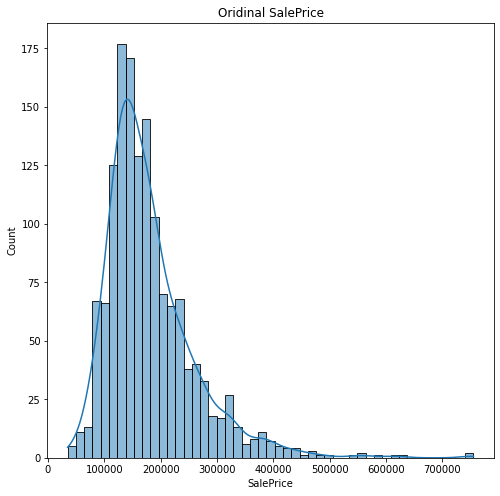

In [73]:
#타겟데이터 분포 확인
plt.figure(figsize=(8,8))
plt.title("Oridinal SalePrice")
sns.histplot(data=df, x='SalePrice', kde=True)
plt.show()

왼쪽으로 치우친 형태를 보임  
로그변환을 이용하여 타겟데이터를 정규분포로 만들어주겠음

In [74]:
def log(df, column):
  df[column] = np.log1p(df[column])
  return df

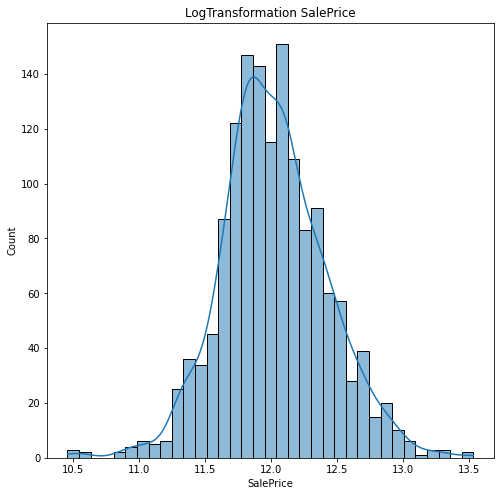

In [75]:
df = log(df, "SalePrice")

plt.figure(figsize=(8,8))
plt.title("LogTransformation SalePrice")
sns.histplot(data=df, x='SalePrice', kde=True)
plt.show()

로그변환을 사용하여 타겟데이터는 정규분포의 모습을 보이는 것을 알 수 있음

In [76]:
#불필요한 데이터 삭제
columns = ['Id', "MiscFeature", "Alley", "Fence", "FireplaceQu","PoolQC"]
df = drop_col(df, columns)

In [77]:
#Null값을 평균값으로 대체
def null_mean(df):
  df = df.fillna(df.mean())
  return df

In [78]:
df = null_mean(df)

In [79]:
#Null 확인
null_column_count = df.isnull().sum()[df.isnull().sum() > 0]
print("## Null 피처의 Type :\n", df.dtypes[null_column_count.index])

## Null 피처의 Type :
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


모든 숫자형 칼럼은 삭제 혹은 평균값으로 대체가 되었고, 문자형 칼러만 남은 것을 확인할 수 있다.  

In [42]:
def one_hot_encoding(df):
  df = pd.get_dummies(df)
  return df

In [80]:
df_copy = df.copy()
print("one hot encoding 수행전 데이터 Shape : ", df.shape)
df = one_hot_encoding(df)
print("one hot encoding 수행후 데이터 Shape : ", df.shape)

#Null 확인
null_column_count = df.isnull().sum()[df.isnull().sum() > 0]
print("## Null 피처의 Type :\n", df.dtypes[null_column_count.index])

one hot encoding 수행전 데이터 Shape :  (1460, 75)
one hot encoding 수행후 데이터 Shape :  (1460, 271)
## Null 피처의 Type :
 Series([], dtype: object)


In [44]:
#전체 전처리함수 
def preprocessing(df, drop_columns, log_column = None):
    df = drop_col(df, drop_columns)
    if log_column != None:
      df = log(df, log_column)
    df = null_mean(df)
    df = one_hot_encoding(df)
    return df

In [18]:
#train, test에 전처리 적용
drop_columns = ['Id', "MiscFeature", "Alley", "Fence", "FireplaceQu","PoolQC"]
log_column = "SalePrice"
train = preprocessing(train, drop_columns, log_column)
test = preprocessing(test, drop_columns)

print("train shape : ", train.shape)
print("test shape : ", test.shape)

train shape :  (1460, 271)
test shape :  (1459, 254)


# 선형 회귀 모델 학습/예측/평가

캐글에서 평가하는 평가지표는 RMSLE(실제값과 예측값의 오류를 로그 변환한뒤에 RMSE를 적용)를 이용  
하지만 target에 이미 로그 변환을 했기때문에 예측한 값도 로그 변환된 값을 반환을 할것이기 때문에 RMSE만 적용하겠음  
RMSLE이가 자동으로 측정이 됨  

In [19]:
#평가지표
from sklearn.metrics import mean_squared_error
def get_rmse(model):
  pred =model.predict(X_test)
  mse = mean_squared_error(y_test, pred)
  rmse = np.sqrt(mse)
  print(model.__class__.__name__, "로그 변환된 RMSE : ", np.round(rmse, 3))
  return rmse

def get_rmses(models):
  rmses = []
  for model in models:
    rmse = get_rmse(model)
    rmses.append(rmse)
  return rmses

선형회귀, 릿지, 라쏘 모델을 사용하여 학습/예측을 수행

In [20]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = train.drop('SalePrice', axis=1)
y = train['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156)

#LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr =LinearRegression()
ridge = Ridge()
lasso = Lasso()
models = [lr, ridge, lasso]
for model in models:
  model.fit(X_train, y_train)

rmses = get_rmses(models)

LinearRegression 로그 변환된 RMSE :  0.132
Ridge 로그 변환된 RMSE :  0.128
Lasso 로그 변환된 RMSE :  0.176


라쏘 회귀의 경우 회귀 성능이 다른 회귀 방식보다 많이 떨어지는 결과가 나왔음  
라쏘의 경우 하이퍼 파라미터 튜닝이 필요해 보임  
피처별 회귀 계수를 시각화해서 어떠한 피처의 회귀 계수를 구성했는지 확인  
상위10개, 하위10개의 피처를 확인하겠음  

상위, 하위10개의 회귀계수를 추출해줄 함수 생성

In [21]:
def get_top_bottom_coef(model, n=10):
  coef = pd.Series(model.coef_, index = X.columns)

  coef_high = coef.sort_values(ascending=False).head(n)
  coef_low = coef.sort_values(ascending=False).tail(n)
  return coef_high, coef_low

시각화를 위한 함수를 생성

In [22]:
def visualize_coef(models):
  # 3개의 회귀 모델의 시각화를 위해 3개의 칼럼을 가지는 subplot 생성
  f, ax = plt.subplots(1,3, figsize=(24,10))
  f.tight_layout()
  # 입력 인자로 받은 list 객체인 models에서 차례로 model을 추출해 회귀 계수 시각화.
  for i, model in enumerate(models):
    coef_high, coef_low = get_top_bottom_coef(model)
    coef_concat = pd.concat([coef_high, coef_low])
  # ax subplot에 barchar로 표현, 한 화면에 표현하기 위해 tick label 위치와 폰트 조정
    ax[i].set_title(model.__class__.__name__ + "Coeffiecents", size=25)
    ax[i].tick_params(axis='y', direction='in', pad=-120)
    for label in (ax[i].get_xticklabels() + ax[i].get_yticklabels()):
      label.set_fontsize(22)
    sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=ax[i])

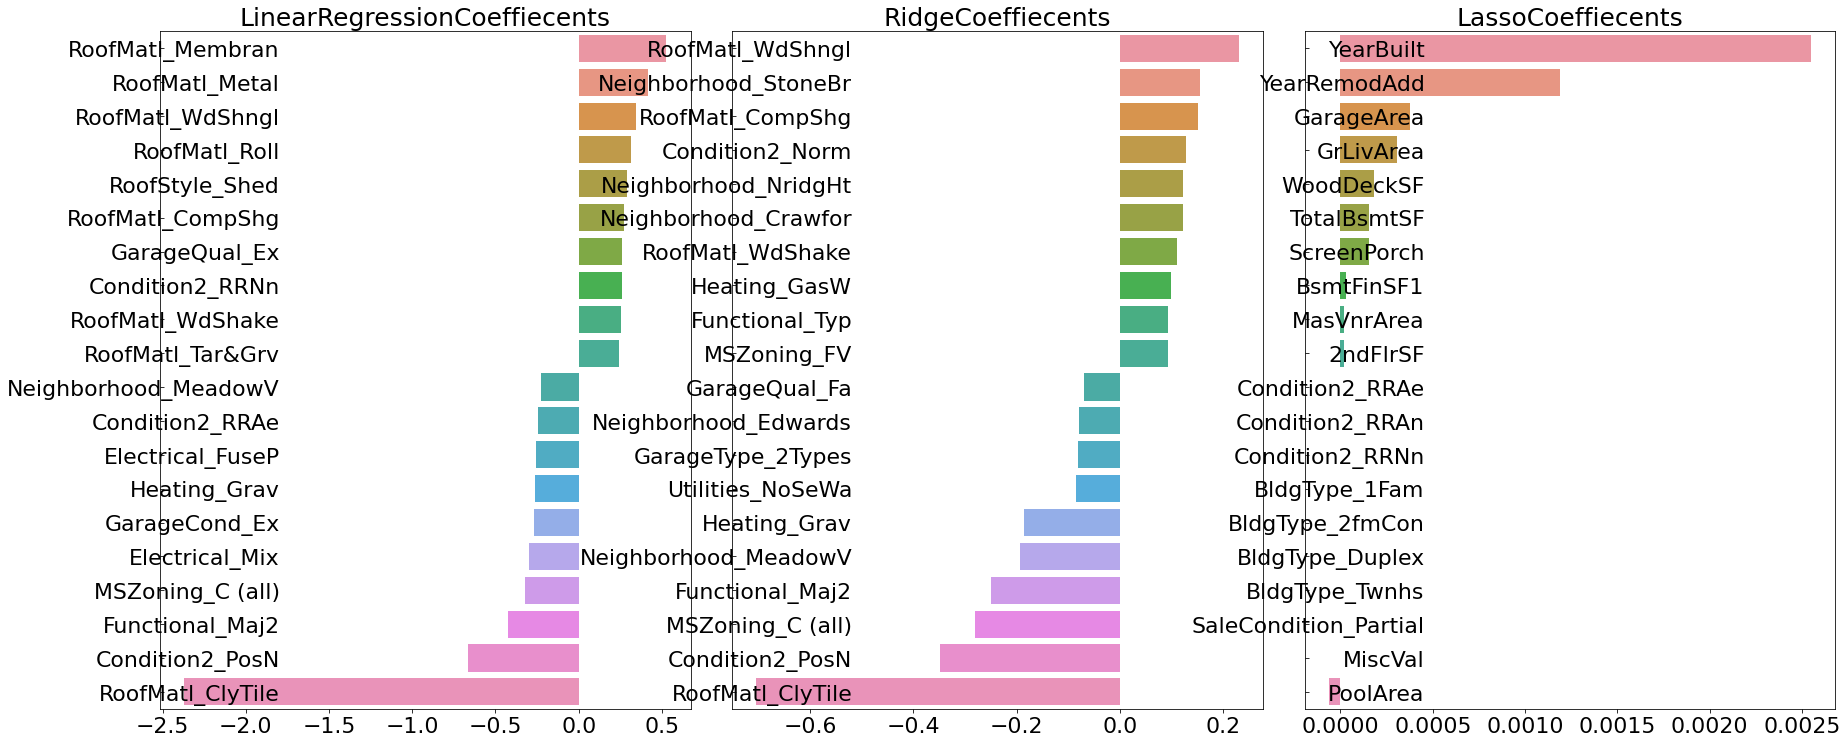

In [23]:
visualize_coef(models)

LineqrRegression, Ridge 모델은 회귀 계수가 유사한데,  
Lasso 모델만 YearBuilt 회귀계수가 가장크고 전체적으로 나머지는 작게 나타났다.  
학습 데이터의 데이터 분할의 문제가 있을 가능성이 있기 때문에   
이번에는 학습/테스트 데이터를 5 fold 교차 검증을 하여 평균 rmse를 측정

In [24]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
  for model in models:
    #분할하지 않고 전체데이터로 cross_val_score()을 수행
    #모델별 CV RMSE와 평균 RSME를 출력
    mse_scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error',cv=5)
    rmse_list = np.sqrt(-mse_scores)
    rmse_avg = np.mean(rmse_list)
    print("\n{} CV RMSE 값 리스트 : {}".format(model.__class__.__name__, np.round(rmse_list,3)))
    print("{} CV 평균 RMSE 값 : {}".format(model.__class__.__name__, np.round(rmse_avg, 3)))

In [25]:
get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트 : [0.135 0.165 0.168 0.111 0.198]
LinearRegression CV 평균 RMSE 값 : 0.155

Ridge CV RMSE 값 리스트 : [0.117 0.154 0.142 0.117 0.189]
Ridge CV 평균 RMSE 값 : 0.144

Lasso CV RMSE 값 리스트 : [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE 값 : 0.198


Lasso 회귀의 경우 릿지나 선형회귀 모델보다 성능이 더 떨어진것을 확인할 수 있음  
alpha 하이퍼 파라미터의 최적의 값을 도출하겠음  

print_best_params() 함수를 만들어 모델과 하이퍼 파라미터 딕셔너리 객체를 받아 최적화 작업의 결과를 표시하겠음  

In [26]:
from sklearn.model_selection import GridSearchCV
def print_best_params(model, params):
  grid_model = GridSearchCV(model, param_grid=params, scoring = "neg_mean_squared_error", cv=5)
  grid_model.fit(X, y)
  rmse = np.sqrt(-1 *grid_model.best_score_)
  print("{} 5 CV 시 최적 평균 RMSE 값 : {}, 최적 alpha : {}".format(model.__class__.__name__, np.round(rmse, 4), grid_model.best_params_))

In [27]:
ridge_params = {"alpha" : [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha' : [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}

print_best_params(ridge, ridge_params)
print_best_params(lasso,lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값 : 0.1418, 최적 alpha : {'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값 : 0.142, 최적 alpha : {'alpha': 0.001}


릿지 회귀의 경우 0.1418, alpha : 12, 라쏘 회귀의 경우 0.142, alpha : 0.001로 라쏘의 경우 성능이 아주 좋아졌음  

하이퍼 파라미터 튜닝을 한 결과와 LinearRegression, Ridge, Lasso를 수행후  
회귀계수를 시각화 해보겠음  

LinearRegression 로그 변환된 RMSE :  0.091
Ridge 로그 변환된 RMSE :  0.104
Lasso 로그 변환된 RMSE :  0.11


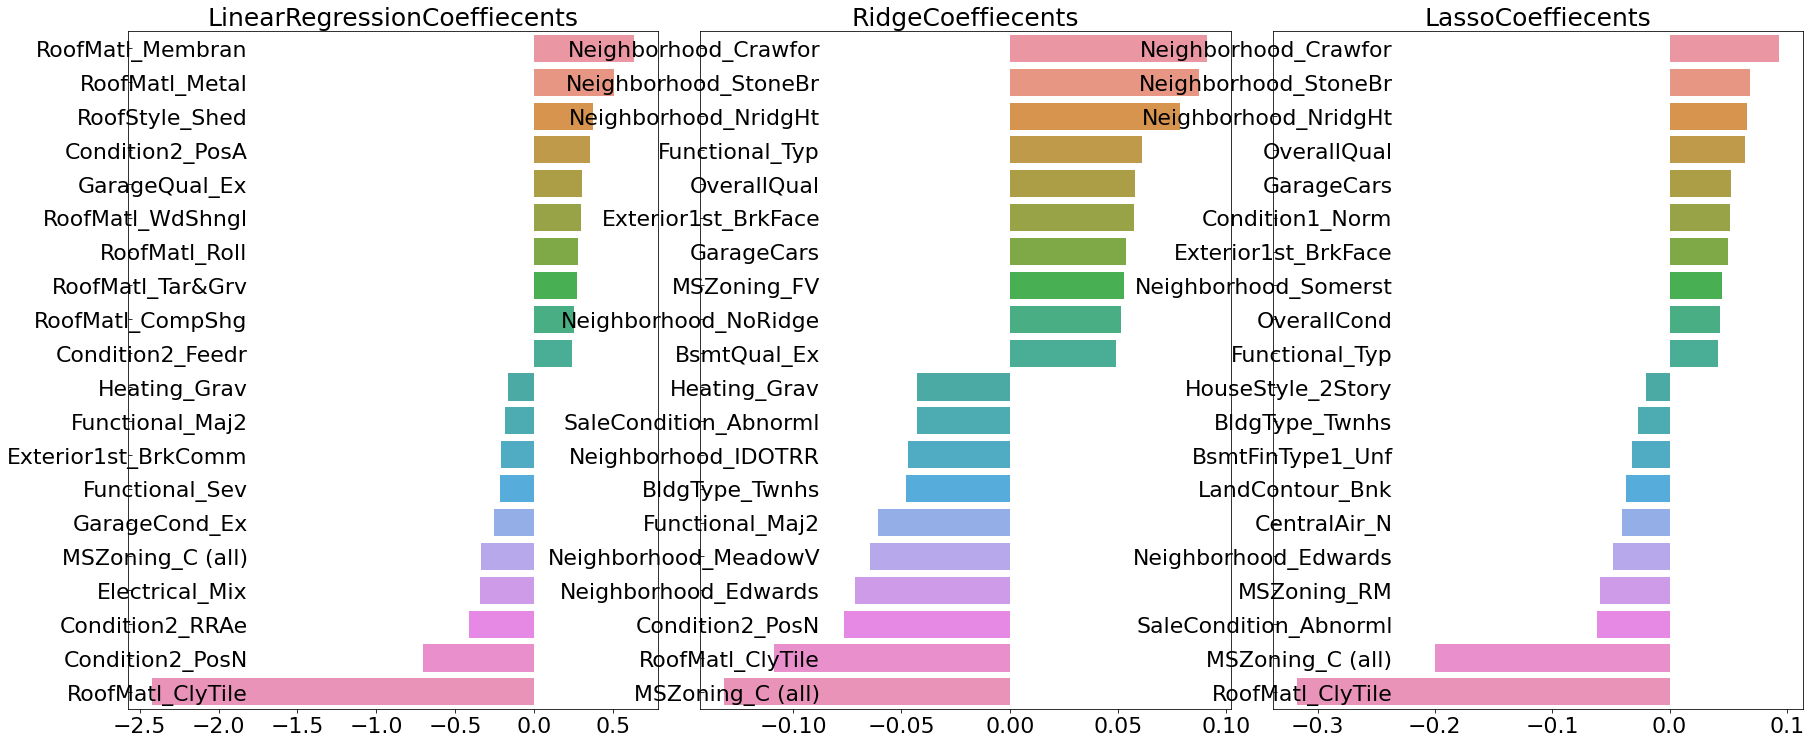

In [28]:
lr = LinearRegression()
ridge = Ridge(alpha=12)
lasso = Lasso(alpha=0.001)

models = [lr, ridge, lasso]
for model in models:
  model.fit(X, y)
rmses = get_rmses(models)

visualize_coef(models)

alpha값 최적화 후에 테스트 데이터 세트의 예측 성능이 더 좋아졌음  
모델 별 회귀 계수도 많이 달라졌음, 기존의 라쏘 모델의 회귀 계수가 나머지 두 개 모델과 많은 차이가 있었지만  
이번에는 릿지, 라쏘 모델에서 비슷한 피처의 회귀 계수가 높음  
하지만 라쏘의 경우 릿지보다 회귀 계수의 값이 상당히 낮음  

## 데이터 전처리2

### 데이터의 왜곡, 이상치 처리

#### 왜곡 처리

피처 데이터 세트의 경우 지나치게 왜곡된 피처가 존재할 경우 회귀 예측 성능을 저하 시킬 수 있음

In [81]:
#scipy의 stats모듈의 skew() 함수를 이요하면 칼럼의 왜곡정도를 쉽게 추출할 수 있음
# 1 이상의 값을 반환한느 피처만 왜곡 정도가 높다고 판단하여 로그 변환을 적용
from scipy.stats import skew
# df_copy = df_copy.drop('SalePrice', axis=1)
# y_target = df_copy['SalePrice']


#object가 아닌 숫자형 피처의 칼럼 Index 객체 추출.
features_index = df_copy.dtypes[df_copy.dtypes != 'object'].index

#df_copy에 칼럼 index를 [] 로 입력하면 해당하는 칼럼 데이터 세트 반환.
#apply lambda로 skew() 호출
skew_features = df_copy[features_index].apply(lambda x : skew(x))
#skew(왜곡)가 1이상인 칼럼만 추출
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


왜곡 정도가 높은 피처를 로그 변환


In [82]:
df_copy[skew_features_top.index] = np.log1p(df_copy[skew_features_top.index])

In [93]:
#왜곡 정도가 높은 피처를 고르 변환했으므로 다시 원-핫 인코딩을 적용하고 피처/ 타깃 데이터 생성
from sklearn.model_selection import train_test_split
df_ohe = pd.get_dummies(df_copy)
X = df_ohe.drop('SalePrice', axis=1)
y = df_ohe['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156)

#피처를 로그 변환한 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = {'alpha' : [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha' : [0.001, 0.005, 0.008, 0.05, 0.03, 0.1,0.5,1,5,10]}
print_best_params(ridge, ridge_params)
print_best_params(lasso, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값 : 0.1275, 최적 alpha : {'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값 : 0.1252, 최적 alpha : {'alpha': 0.001}


두 모델 모두 피처의 로그 변환 이전과 비교해 성능이 향상된것을 볼 수 있음  


LinearRegression 로그 변환된 RMSE :  0.09
Ridge 로그 변환된 RMSE :  0.102
Lasso 로그 변환된 RMSE :  0.109


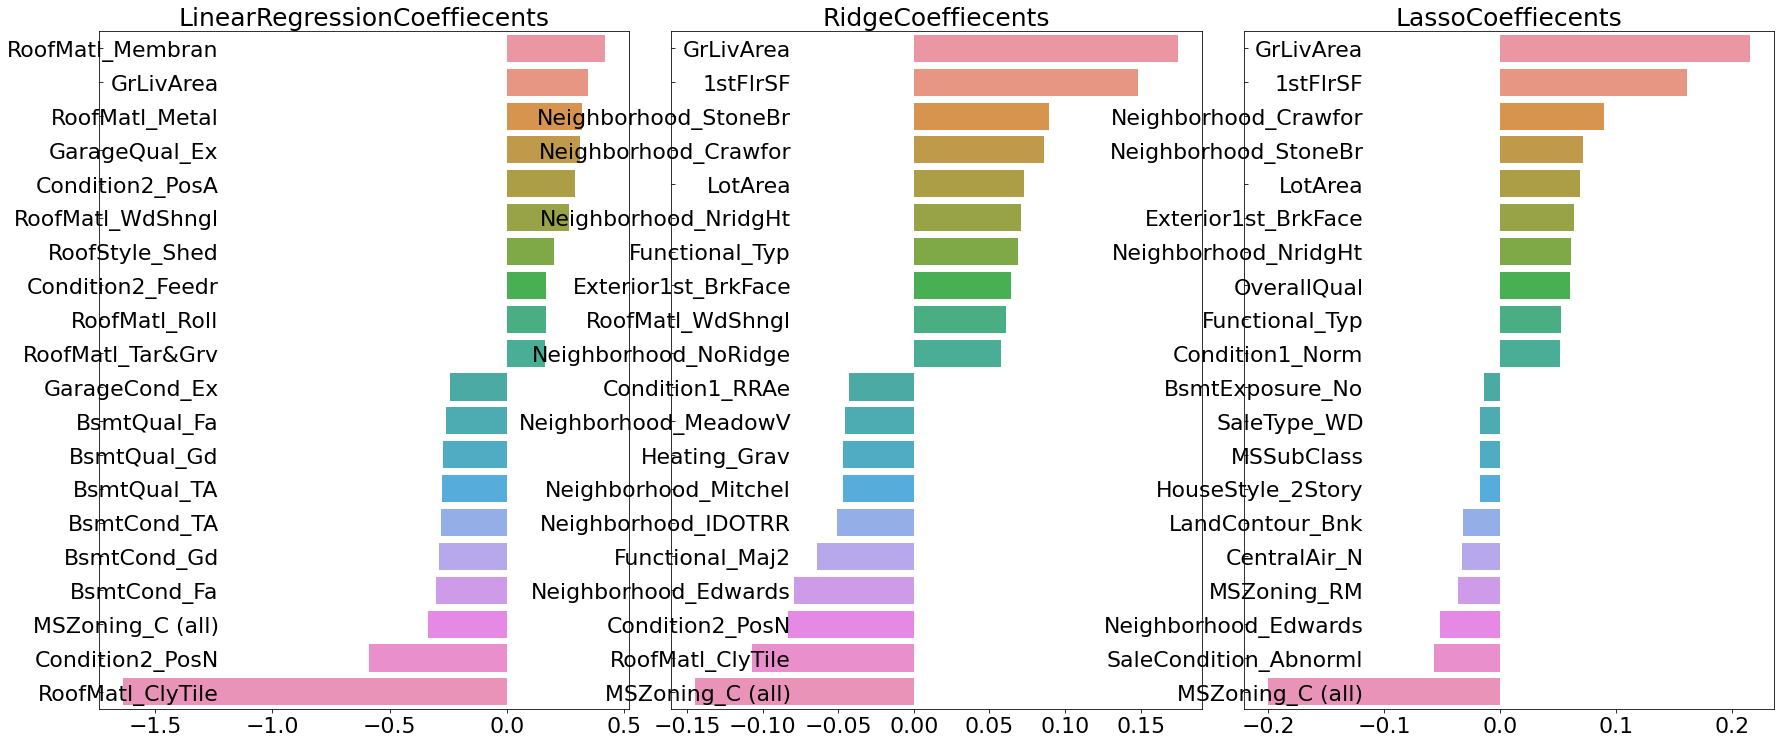

In [94]:
lr = LinearRegression()
ridge = Ridge(alpha=10)
lasso = Lasso(alpha=0.001)


models = [lr, ridge, lasso]
for model in models:
  model.fit(X, y)
rmses = get_rmses(models)

visualize_coef(models)

GrLivArea(주거 공간 크기)가 회귀 계수가 가장 높은 피처가 되었음  
주거 공간의 크기가 주택 가격에 미치는 영향이 당연히 제일 높을 것이라는 상식선의 결과가 도출이 됨

#### 이상치 처리

회귀 계수가 높은 피처 즉, 예측에 많은 영향을 미치는 중요 피처의 이상치 데이터의 처리가 중요함 

GrLivArea 피처의 데이터 분포를 확인

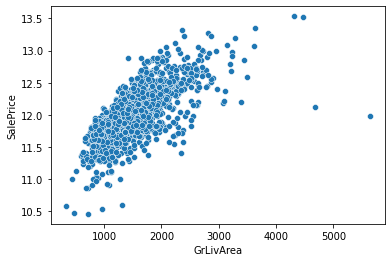

In [95]:
sns.scatterplot(data=df, x='GrLivArea', y='SalePrice')
plt.show()

In [99]:
#GrLivArea와  SalePrice 모두 로그 변환 되었음으로 이를 반영한 조건 생성
cond1 = df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = df_ohe['SalePrice'] > np.log1p(500000)
outlier_index = df_ohe[cond1 & cond2].index

print("이상치 레코드 index : ", outlier_index)
print("이상치 삭제 전 df_ohe Shape", df_ohe.shape)

#DataFrame의 인덱스를 이용해 이상치 레코드 삭제.
df_ohe = df_ohe.drop(outlier_index, axis=0)
print("이상치 삭제 후 df_ohe Shape", df_ohe.shape)

이상치 레코드 index :  Int64Index([], dtype='int64')
이상치 삭제 전 df_ohe Shape (1458, 271)
이상치 삭제 후 df_ohe Shape (1458, 271)


레코드 수가 2개 줄어든것을 확인할 수 있음

In [100]:
X = df_ohe.drop('SalePrice', axis=1)
y = df_ohe['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156)

#피처를 로그 변환한 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = {'alpha' : [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha' : [0.001, 0.005, 0.008, 0.05, 0.03, 0.1,0.5,1,5,10]}
print_best_params(ridge, ridge_params)
print_best_params(lasso, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값 : 0.1272, 최적 alpha : {'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값 : 0.1249, 최적 alpha : {'alpha': 0.001}


LinearRegression 로그 변환된 RMSE :  0.085
Ridge 로그 변환된 RMSE :  0.09
Lasso 로그 변환된 RMSE :  0.093


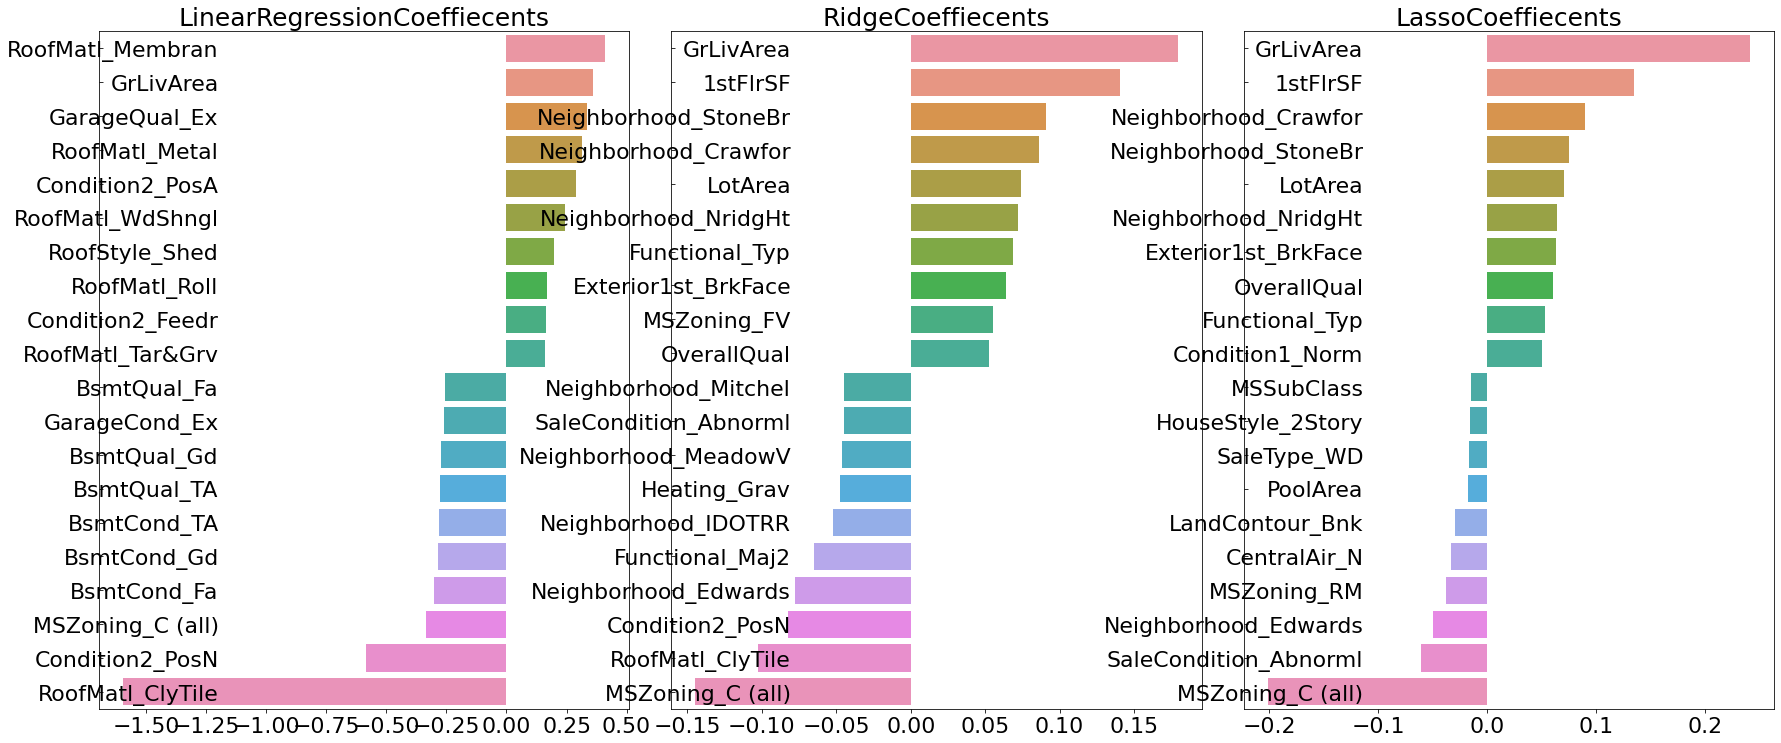

In [98]:
lr = LinearRegression()
ridge = Ridge(alpha=10)
lasso = Lasso(alpha=0.001)


models = [lr, ridge, lasso]
for model in models:
  model.fit(X, y)
rmses = get_rmses(models)

visualize_coef(models)

이상치를 처리하니 성능이 약간 향상된것을 알수 있음